# Forecasting price of Bitcoin with Prophet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from prophet import Prophet

c:\Users\33680\Desktop\projet_camelia\envProject\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
train_size, test_size, start = 758, 200, 2265 # window on which we fit and test our model

n_input = 20 # window used by the model to forecast the next step

data = pd.read_csv('data/bitcoin.csv')

data.iloc[start:start+train_size]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
2265,2013-08-19,427.253540,434.371857,427.124023,431.208710,3635375,0,0.0
2266,2013-08-20,432.553680,434.426666,430.157654,431.094147,2475243,0,0.0
2267,2013-08-21,433.699402,436.817688,431.632141,433.041840,3527774,0,0.0
2268,2013-08-22,434.720551,435.741730,433.500122,435.223663,1746321,0,0.0
2269,2013-08-23,437.275970,437.360657,433.251068,433.480225,2162274,0,0.0
...,...,...,...,...,...,...,...,...
3018,2016-08-15,783.750000,787.489990,780.109985,782.440002,938200,0,0.0
3019,2016-08-16,780.299988,780.979980,773.443970,777.140015,1028000,0,0.0
3020,2016-08-17,777.320007,780.809998,773.530029,779.909973,924200,0,0.0
3021,2016-08-18,780.010010,782.859985,777.000000,777.500000,719400,0,0.0


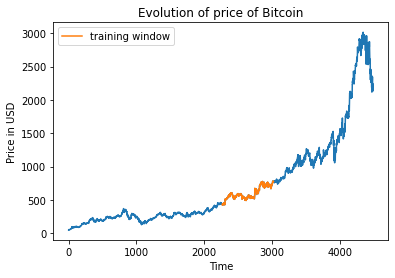

In [3]:
price = data['Close']

plt.plot(price)
plt.plot(price.iloc[start:start+train_size], label='training window')
plt.title('Evolution of price of Bitcoin')
plt.ylabel('Price in USD')
plt.xlabel('Time')
plt.legend()
plt.show()

In [4]:
log_price = price.map(np.log)

log_ret = pd.Series(data=np.diff(log_price, 1), index=log_price.index[1:], name='log returns')

scaler = MinMaxScaler()

log_ret_rescale = scaler.fit_transform(log_ret.to_numpy().reshape((-1,1)))

In [5]:
model = Prophet()

train_df = pd.DataFrame({
    'ds': data['Date'].iloc[start:start+train_size],
    'y': log_ret_rescale[start-1:start+train_size-1,0]
})

model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [6]:
future = model.make_future_dataframe(periods=test_size)

forecast = model.predict(future)

forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
953,2017-03-03,0.411684,0.349974,0.476412,0.411291,0.412120,-0.000233,-0.000233,-0.000233,-0.004079,-0.004079,-0.004079,0.003845,0.003845,0.003845,0.0,0.0,0.0,0.411450
954,2017-03-04,0.411687,0.362305,0.490806,0.411293,0.412126,0.014138,0.014138,0.014138,0.010456,0.010456,0.010456,0.003681,0.003681,0.003681,0.0,0.0,0.0,0.425825
955,2017-03-05,0.411690,0.361347,0.488615,0.411292,0.412134,0.013887,0.013887,0.013887,0.010456,0.010456,0.010456,0.003430,0.003430,0.003430,0.0,0.0,0.0,0.425577
956,2017-03-06,0.411694,0.339880,0.469189,0.411290,0.412139,-0.005178,-0.005178,-0.005178,-0.008266,-0.008266,-0.008266,0.003088,0.003088,0.003088,0.0,0.0,0.0,0.406516
957,2017-03-07,0.411697,0.348379,0.475703,0.411287,0.412145,0.001003,0.001003,0.001003,-0.001647,-0.001647,-0.001647,0.002651,0.002651,0.002651,0.0,0.0,0.0,0.412701


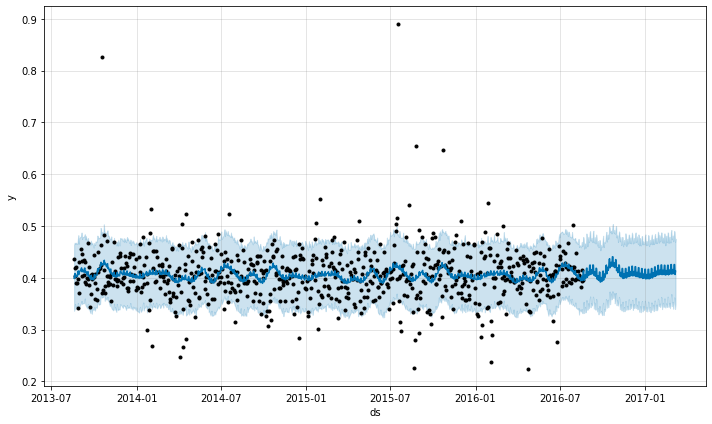

In [7]:
fig = model.plot(forecast)

In [8]:
log_ret_preds = scaler.inverse_transform(forecast['yhat'].to_numpy().reshape((-1,1)))

score_matrix = np.zeros(shape=(2,2))

for i in range(test_size):

    if log_ret_preds[i] >= 0 and log_ret.iloc[start+train_size+i].item() >= 0:
        score_matrix[0,0] += 1
    
    elif log_ret_preds[i] < 0 and log_ret.iloc[start+train_size+i].item() < 0:
        score_matrix[1,1] += 1
    
    elif log_ret_preds[i] >= 0 and log_ret.iloc[start+train_size+i].item() < 0:
        score_matrix[1,0] += 1

    elif log_ret_preds[i] < 0 and log_ret.iloc[start+train_size+i].item() >= 0:
        score_matrix[1,1] += 1
    

score_matrix    

array([[81.,  0.],
       [54., 65.]])